In [1]:
#pip install threadpoolctl==3.1.0 --> 오버샘플링 버전 연동 확인 

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import numpy as np
from numpy import array

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy
from scipy import stats,interpolate
from scipy.stats import skew,kurtosis,describe,variation,shapiro,levene,f_oneway
from scipy.special import kl_div
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import warnings 
warnings.filterwarnings(action='ignore')

import optuna
from optuna.integration import XGBoostPruningCallback
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn import model_selection
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, KFold 
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,IsolationForest,StackingClassifier
from sklearn.metrics import accuracy_score,balanced_accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,fbeta_score,roc_auc_score,classification_report,make_scorer,balanced_accuracy_score
from mlxtend.classifier import StackingClassifier,StackingCVClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler,RobustScaler,Binarizer

from imblearn.over_sampling import SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.under_sampling import RandomUnderSampler,NearMiss,TomekLinks,CondensedNearestNeighbour,EditedNearestNeighbours

import random
import tensorflow 
import tensorflow as tf

random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
def describex(data):
        data = pd.DataFrame(data)
        stats = data.describe()
        skewness = data.skew()
        kurtosis = data.kurtosis()
        skewness_df = pd.DataFrame({'skewness':skewness}).T
        kurtosis_df = pd.DataFrame({'kurtosis':kurtosis}).T
        Appended_Stats = pd.concat([stats,skewness_df,kurtosis_df],axis=0)
        return Appended_Stats

In [4]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    f1 = f1_score(y_test,pred)
    f2 = fbeta_score(y_test,pred,beta=2)
    balanced_acc = balanced_accuracy_score(y_test,pred)
    print('Confusion Matrix')
    print(confusion)
    print('\n')
    print('정확도:',accuracy.round(3),'정밀도:', precision.round(3),'재현율:',recall.round(3),'AUC:',roc_auc.round(3),'F1:',f1.round(3),'F2:',f2.round(3),'Balanced_Accuracy:',balanced_acc.round(3))

In [5]:
data1 = pd.read_csv('데이터셋압축/MEASURED_WAVE_TRAIN.csv',encoding='cp949')
df1 =  pd.DataFrame(data1.MEASURED_WAVE.str.split(',').tolist()) # 콤마 제거 이후 열 형태로 변경
df1.columns = 'MEASURED_WAVE_' + df1.columns.astype(str)
data1 = pd.concat([data1[['REFERENCE_ID','QUALITY']],df1],axis=1)
data1 = data1.drop_duplicates(subset=['REFERENCE_ID']) # REFERENCE_ID 중복 제거 

data2 = pd.read_csv('데이터셋압축/REFERENCE_WAVE.csv',encoding='cp949')
df2 =  pd.DataFrame(data2.REFERENCE_WAVE.str.split(',').tolist()) # 콤마 제거 이후 열 형태로 변경 
df2.columns = 'REFERENCE_WAVE_' + df2.columns.astype(str)
data2 = pd.concat([data2[['REFERENCE_ID']],df2],axis=1)


for col in data1.columns:

            try : data1[col] = data1[col].astype('float')
            except: pass     
            
            
for col in data2.columns:

            try : data2[col] = data2[col].astype('float')
            except: pass  
            
data_full = pd.merge(data1,data2,how='inner',on = 'REFERENCE_ID').dropna()
data_full['QUALITY'] = data_full['QUALITY'].replace({'GOOD':0,'BAD':1})

In [6]:
data_full.shape

(9407, 402)

In [7]:
data_full['QUALITY'].value_counts()

QUALITY
0    9076
1     331
Name: count, dtype: int64

In [8]:
#data_full = reduce_mem_usage(data_full)

In [9]:
Feature_Selection = False

In [10]:
def Train_Test_Split(Feature_Selection):
    
    Data = data_full
    Input_Data = data_full.drop(['REFERENCE_ID','QUALITY'],axis=1)
    
    X = Input_Data
    y = Data['QUALITY']
    
    if Feature_Selection == False:

        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2021)
        
        ros_test = RandomUnderSampler(sampling_strategy=0.8,random_state=2021)   
        X_test,y_test = ros_test.fit_resample(X_test,y_test)    

        return X_train, y_train, X_test, y_test
    
    if Feature_Selection == True:
        
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2021)
        Train = pd.concat([X_train,y_train],axis=1)
        Pass = Train[Train['QUALITY']==0].drop(['QUALITY'],axis=1)
        Fail = Train[Train['QUALITY']==1].drop(['QUALITY'],axis=1)

        T_Test = stats.ttest_ind(Pass,Fail,equal_var=False) # equal_var=True
        Columns = pd.DataFrame(X_train.columns).rename(columns={0:'Columns'})
        P_Value = pd.DataFrame(T_Test[1]).rename(columns={0:'P-Value'})
        Concat_columns_pvalues = pd.concat([Columns,P_Value],axis=1).dropna()

        Significant_Values = Concat_columns_pvalues[Concat_columns_pvalues['P-Value'] < 0.05]['Columns'].to_list()
        df_ttest = Data[Significant_Values]
        
        X_train,X_test,y_train,y_test = train_test_split(df_ttest,y,test_size=0.2,random_state=2021)
        
        ros_test = RandomUnderSampler(sampling_strategy=0.8,random_state=2021)   
        X_test,y_test = ros_test.fit_resample(X_test,y_test)    

        return X_train, y_train, X_test, y_test 
    
X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
X_train.shape, X_test.shape

((7525, 400), (139, 400))

In [11]:
y_train.value_counts(),y_test.value_counts()

(QUALITY
 0    7256
 1     269
 Name: count, dtype: int64,
 QUALITY
 0    77
 1    62
 Name: count, dtype: int64)

In [12]:
# T-Test & Top10 Corr Feature Selection

Train_Features = pd.concat([X_train,y_train],axis=1)
df_corr =Train_Features.corr().iloc[1:,-1]
df_corr = pd.DataFrame(df_corr).rename(columns={'QUALITY':'Corr'}).abs().reset_index()
df_corr = df_corr.sort_values(by='Corr',ascending = False).iloc[1:]
Top10_Corr = df_corr.head(10)['index'].to_list()

#X_train = X_train[Top10_Corr]
#X_test = X_test[Top10_Corr]

#X_train.shape, X_test.shape

In [13]:
#### Corr Feature Selection

#Data = data_full
#Input_Data = data_full.drop(['REFERENCE_ID','QUALITY'],axis=1)

#X = Input_Data
#y = Data['QUALITY']

#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2021)
#Train = pd.concat([X_train,y_train],axis=1)

#df_corr = Train.corr().iloc[1:,-1]
#df_corr = pd.DataFrame(df_corr).rename(columns={'QUALITY':'Corr'}).abs().reset_index()
#df_corr = df_corr.sort_values(by='Corr',ascending = False).iloc[1:]
#df_corr = df_corr[df_corr['Corr'] >= 0.2] # 데이터마다 상관계수 최소값 다름 
#Corr_Values = df_corr['index'].to_list()

#df_Corr = Data[Corr_Values]
#X_train,X_test,y_train,y_test = train_test_split(df_Corr,y,test_size=0.2,random_state=2021)

#ros_test = RandomUnderSampler(sampling_strategy=0.8,random_state=2021)   
#X_test,y_test = ros_test.fit_resample(X_test,y_test)    

#X_train.shape,X_test.shape

In [14]:
#### VIF Feature Selection

#Data = data_full
#Input_Data = data_full.drop(['REFERENCE_ID','QUALITY'],axis=1)

#X = Input_Data
#y = Data['QUALITY']
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=2021)
#Train = pd.concat([X_train,y_train],axis=1)

#X = Train.drop(['QUALITY'],axis=1)
#scaler = StandardScaler()
#scale_cols =  X.columns
#scaled_X = scaler.fit_transform(X[scale_cols])
#scaled_X = pd.DataFrame(scaled_X, columns=scale_cols)
#scaled_X = scaled_X.set_index(X.index)

#vif = pd.DataFrame()
#vif['VIF_Factor'] = [variance_inflation_factor(scaled_X.values, i) 
                     #for i in range(scaled_X.shape[1])]
#X_Columns = pd.DataFrame(scaled_X.columns).rename(columns={0:'Columns'})

#df_vif = pd.concat([X_Columns,vif],axis=1)
#df_VIF = Data[df_vif[df_vif['VIF_Factor'] <= 10]['Columns'].to_list()]

#X_train,X_test,y_train,y_test = train_test_split(df_VIF,y,test_size=0.1,random_state=2021)

#ros_test = RandomUnderSampler(sampling_strategy=0.8,random_state=2021)   
#X_test,y_test = ros_test.fit_resample(X_test,y_test)    

In [15]:
# 활용할 ML 나열 
rf = RandomForestClassifier(random_state=2021)
rf_bal = RandomForestClassifier(random_state=2021,class_weight='balanced')
ada = AdaBoostClassifier(random_state=2021)
gbm = GradientBoostingClassifier(random_state=2021)
xgb = XGBClassifier(random_state=2021)
xgb_bal = XGBClassifier(random_state=2021,scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])
lgbm =  LGBMClassifier(random_state=2021)
lgbm_bal = LGBMClassifier(random_state=2021,scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]) 

models = [rf,rf_bal,ada,gbm,xgb,xgb_bal,lgbm,lgbm_bal]

In [16]:
def test_model(model):
        
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
    
    ml = model
    ml.fit(X_train,y_train)      
    pred = ml.predict(X_test)
    pred_proba = ml.predict_proba(X_test)[:,1]
    print('----------------------------------------------------------------------------------------------------------')
    get_clf_eval(y_test,pred,pred_proba)  
    print('\n')
    print(classification_report(y_test, pred,target_names=['양품','불량']))
    
    if model == rf:
        print('RandomForest Prediction Result')
        print('\n')
        
    elif model == rf_bal:
        print('RandomForest(Balanced Weight) Prediction Result')
        print('\n')  
        
    elif model == ada:
        print('AdaBoost Prediction Result')
        print('\n')
     
    elif model == gbm:
        print('GradientBoostingMachine Prediction Result')
        print('\n')
        
    elif model == xgb:
        print('XGBoost Prediction Result')
        print('\n')
        
    elif model == xgb_bal:
        print('XGBoost(Balanced Weight) Prediction Result')
        print('\n')    
        
    elif model == lgbm:
        print('LightGBM Prediction')
        print('\n')   
        
    elif model == lgbm_bal:
        print('LightGBM(Balanced Weight) Prediction Result')

In [17]:
# 전체 모델  원큐 출력 
#for i in range(0,len(models)):

#    model = models[i]
#    test_model(model) 

In [18]:
test_model(models[7]) 

----------------------------------------------------------------------------------------------------------
Confusion Matrix
[[77  0]
 [17 45]]


정확도: 0.878 정밀도: 1.0 재현율: 0.726 AUC: 0.999 F1: 0.841 F2: 0.768 Balanced_Accuracy: 0.863


              precision    recall  f1-score   support

          양품       0.82      1.00      0.90        77
          불량       1.00      0.73      0.84        62

    accuracy                           0.88       139
   macro avg       0.91      0.86      0.87       139
weighted avg       0.90      0.88      0.87       139

LightGBM(Balanced Weight) Prediction Result


In [19]:
#pip install threadpoolctl==3.1.0

In [20]:
def Oversampling_Test(model):
    
    #X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)

    for i in list(np.arange(0.65,1.05,0.05).round(2)): # sampling_strategy = 0.65, 0.7 , 0.75, 0.8 ,0.85, 0.9, 0.95, 1.0
        oversampler = SMOTEENN(sampling_strategy=i,random_state=2021)
        X_train_over,y_train_over = oversampler.fit_resample(X_train,y_train)
        ml = model
        ml.fit(X_train_over,y_train_over) 
        pred = ml.predict(X_test)
        pred_proba = ml.predict_proba(X_test)[:,1]
        get_clf_eval(y_test,pred,pred_proba)  
        print('\n')
        print(classification_report(y_test, pred,target_names=['양품','불량']))
        
        if model == rf:
            print('RandomForest SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == rf_bal:
            print('RandomForest(Balanced Weight) SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')   

        elif model == ada:
            print('AdaBoost SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == gbm:
            print('GradientBoostingMachine SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == xgb:
            print('XGBoost SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == xgb_bal:
            print('XGBoost(Balanced Weight) SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    


        elif model == lgbm:
            print('LightGBM SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')   
            
        elif model == lgbm_bal:
            print('LightGBM(Balanced Weight) SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')          
            
models = [rf,rf_bal,ada,gbm,xgb,xgb_bal,lgbm,lgbm_bal]

In [21]:
#Oversampling_Test(models[0])

In [22]:
#Oversampling_Test(models[1])

In [23]:
#Oversampling_Test(models[2])

In [24]:
#Oversampling_Test(models[3])

In [25]:
#Oversampling_Test(models[4])

In [26]:
Oversampling_Test(models[5])

Confusion Matrix
[[76  1]
 [ 2 60]]


정확도: 0.978 정밀도: 0.984 재현율: 0.968 AUC: 0.999 F1: 0.976 F2: 0.971 Balanced_Accuracy: 0.977


              precision    recall  f1-score   support

          양품       0.97      0.99      0.98        77
          불량       0.98      0.97      0.98        62

    accuracy                           0.98       139
   macro avg       0.98      0.98      0.98       139
weighted avg       0.98      0.98      0.98       139

XGBoost(Balanced Weight) SMOTEENN=0.65 Prediction Result
------------------------------------------------------------------------------------------------------


Confusion Matrix
[[76  1]
 [ 4 58]]


정확도: 0.964 정밀도: 0.983 재현율: 0.935 AUC: 0.999 F1: 0.959 F2: 0.945 Balanced_Accuracy: 0.961


              precision    recall  f1-score   support

          양품       0.95      0.99      0.97        77
          불량       0.98      0.94      0.96        62

    accuracy                           0.96       139
   macro avg       0.97      0.96  

In [27]:
#Oversampling_Test(models[6])

In [28]:
#Oversampling_Test(models[7])

In [29]:
def Undersampling_Test(model):
     
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)

    for i in list(np.arange(0.65,1.05,0.05).round(2)): # sampling_strategy = 0.65, 0.7 , 0.75, 0.8 ,0.85, 0.9, 0.95, 1.0
        undersampler = RandomUnderSampler(sampling_strategy=i,random_state=2021) 
        #undersampler = NearMiss() --> ROS 이외의 언더샘플링 진행시 for 반복문 해제 
        # TomekLink(), NearMiss, EditedNearestNeigbours,CondensedNearestNeighbour
        
        X_train_under,y_train_under = undersampler.fit_resample(X_train,y_train)
        ml = model
        ml.fit(X_train_under,y_train_under) 
        pred = ml.predict(X_test)
        pred_proba = ml.predict_proba(X_test)[:,1]
        get_clf_eval(y_test,pred,pred_proba)  
        print('\n')
        print(classification_report(y_test, pred,target_names=['양품','불량']))
        
        if model == rf:
            print('RandomForest ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == rf_bal:
            print('RandomForest(Balanced Weight) ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    

        elif model == ada:
            print('AdaBoost ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == gbm:
            print('GradientBoostingMachine ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == xgb:
            print('XGBoost ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == xgb_bal:
            print('XGBoost(Balanced Weight) ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    


        elif model == lgbm:
            print('LightGBM ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')   
            
        elif model == lgbm_bal:
            print('LightGBM(Balanced Weight) ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')          
            
models = [rf,rf_bal,ada,gbm,xgb,xgb_bal,lgbm,lgbm_bal]

In [30]:
#Undersampling_Test(models[0])

In [31]:
#Undersampling_Test(models[1])

In [32]:
#Undersampling_Test(models[2])

In [33]:
#Undersampling_Test(models[3])

In [34]:
#Undersampling_Test(models[4])

In [35]:
Undersampling_Test(models[5])

Confusion Matrix
[[75  2]
 [ 2 60]]


정확도: 0.971 정밀도: 0.968 재현율: 0.968 AUC: 0.997 F1: 0.968 F2: 0.968 Balanced_Accuracy: 0.971


              precision    recall  f1-score   support

          양품       0.97      0.97      0.97        77
          불량       0.97      0.97      0.97        62

    accuracy                           0.97       139
   macro avg       0.97      0.97      0.97       139
weighted avg       0.97      0.97      0.97       139

XGBoost(Balanced Weight) ROS=0.65 Prediction Result
------------------------------------------------------------------------------------------------------


Confusion Matrix
[[75  2]
 [ 3 59]]


정확도: 0.964 정밀도: 0.967 재현율: 0.952 AUC: 0.996 F1: 0.959 F2: 0.955 Balanced_Accuracy: 0.963


              precision    recall  f1-score   support

          양품       0.96      0.97      0.97        77
          불량       0.97      0.95      0.96        62

    accuracy                           0.96       139
   macro avg       0.96      0.96      0

In [36]:
#Undersampling_Test(models[6])

In [37]:
#Undersampling_Test(models[7])

In [38]:
def preprocessing():
    
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
    #undersampler = RandomUnderSampler(sampling_strategy=1.0,random_state=2021) 
    #X_train,y_train = undersampler.fit_resample(X_train,y_train)
    
    Train_All = pd.concat([X_train,y_train],axis=1)
    X_train_Normal = Train_All[Train_All['QUALITY']==0].drop(['QUALITY'],axis=1)

    scaler = MinMaxScaler()
    scaler.fit(X_train_Normal) # Train Data 기준으로 Train/Test 스케일링 진행 

    X_train_Normal = pd.DataFrame(scaler.transform(X_train_Normal),columns = X_train_Normal.columns)
    X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)
    
    return X_train_Normal, X_test , y_train ,y_test

X_train_Normal, X_test , y_train ,y_test = preprocessing()

In [39]:
X_train_Normal.shape, X_test.shape

((7256, 400), (139, 400))

In [40]:
y_train.value_counts(),y_test.value_counts()

(QUALITY
 0    7256
 1     269
 Name: count, dtype: int64,
 QUALITY
 0    77
 1    62
 Name: count, dtype: int64)

In [41]:
def build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio):
    
    random.seed(1234)
    np.random.seed(1234)
    tf.random.set_seed(1234)
    
    input_layer = Input(shape = (X.shape[1],))
    
    encoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(input_layer)
    encoded = Dropout(dropout_ratio)(encoded)
    encoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    
    encoded = Dense(latent_vector, activation = function)(encoded) 
    
    decoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    decoded = Dropout(dropout_ratio)(decoded)
    decoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)
    
    output_layer = Dense(X.shape[1], activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [42]:
def train_autoencoder(model,X,batch,epoch,val,patience):
    history = model.fit(X, X,
                              batch_size = batch, epochs = epoch, 
                              validation_split = val,callbacks=EarlyStopping(patience=patience))
    
    print('\n')
    sns.set(font_scale=1.0)
    plt.figure(figsize=(6,4))
    plt.grid(True)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.xlabel('Epoch'); plt.ylabel('loss')
    plt.show()

    return history 

In [43]:
X = X_train_Normal

outer = 256
inner = 128
latent_vector = 64
dropout_ratio = 0.2
function = 'relu'

batch = 100
epoch = 1000
val = 0.2
patience = 10

Epoch 1/1000
59/59 [==============================] - 2s 11ms/step - loss: 0.0676 - val_loss: 0.0388
Epoch 2/1000
59/59 [==============================] - 0s 5ms/step - loss: 0.0395 - val_loss: 0.0367
Epoch 3/1000
59/59 [==============================] - 0s 4ms/step - loss: 0.0273 - val_loss: 0.0213
Epoch 4/1000
59/59 [==============================] - 0s 5ms/step - loss: 0.0211 - val_loss: 0.0192
Epoch 5/1000
59/59 [==============================] - 0s 5ms/step - loss: 0.0198 - val_loss: 0.0183
Epoch 6/1000
59/59 [==============================] - 0s 5ms/step - loss: 0.0186 - val_loss: 0.0171
Epoch 7/1000
59/59 [==============================] - 0s 5ms/step - loss: 0.0178 - val_loss: 0.0153
Epoch 8/1000
59/59 [==============================] - 0s 4ms/step - loss: 0.0152 - val_loss: 0.0131
Epoch 9/1000
59/59 [==============================] - 0s 5ms/step - loss: 0.0134 - val_loss: 0.0115
Epoch 10/1000
59/59 [==============================] - 0s 5ms/step - loss: 0.0121 - val_loss: 0.010

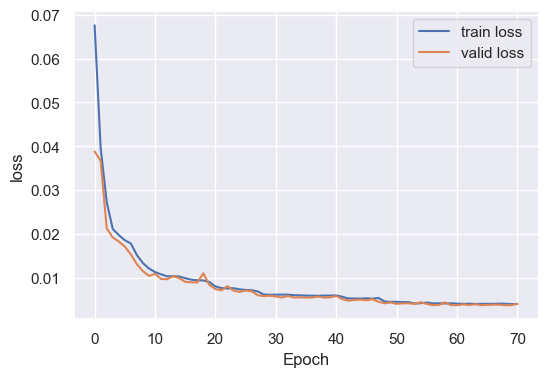

In [44]:
autoencoder = build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio)

history = train_autoencoder(autoencoder,X,batch,epoch,val,patience)

In [45]:
def reconstruction_loss(model,x_train,x_test):
    
    x_train_pred  = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

    print('\n')
    plt.figure(figsize=(6,4))
    plt.title('Reconstruction MAE Loss')
    plt.hist(train_mae_loss, bins=40,color='blue',density=True,label='Train')
    plt.hist(test_mae_loss, bins=40,color='red',density=True,label='Test')
    plt.legend()
    plt.show()

    threshold_train = np.max(train_mae_loss) 
    threshold_test = np.max(test_mae_loss) 
    print('\n')
    print("Train (Normal Only) Reconstruction error threshold:", threshold_train)
    print('\n')
    print("Test Reconstruction error threshold:", threshold_test)
    
    #anomalies = threshold_test > threshold_train
    #print('\n')
    #print("Train Threshold Based Detected Anomalies: ", np.sum(anomalies))
    #print("Real Normal Labels from Test Data : ", y_test.value_counts()[0])
    #print("Real Fault Labels from Test Data : ", y_test.value_counts()[1])
    
    return train_mae_loss, test_mae_loss, threshold_train, threshold_test

5/5 [==============================] - 0s 2ms/step




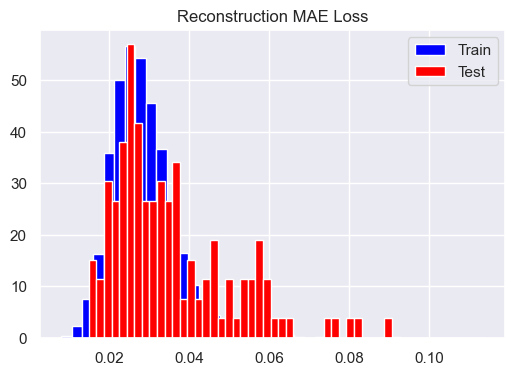



Train (Normal Only) Reconstruction error threshold: 0.11377470067796264


Test Reconstruction error threshold: 0.09069858186150666


In [46]:
train_mae_loss, test_mae_loss, threshold_train, threshold_test = reconstruction_loss(autoencoder,X_train_Normal,X_test)

In [47]:
def anomaly_threshold(threshold,model):
    test_score_df = pd.DataFrame(X_test[:])
    test_score_df['loss'] = test_mae_loss # --> pred_proba
    test_score_df['threshold'] = threshold # 레이블 예측 임계값 
    test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
    test_score_df['score'] = test_score_df["anomaly"].astype(int) # 예측 레이블 
    get_clf_eval(y_test,test_score_df['score'],test_score_df['loss'])
    print('\n')
    print(classification_report(y_test, test_score_df['score'],target_names=['양품','불량']))
    
    test_error = pd.DataFrame({'Reconstruction_error': test_mae_loss,'True_class': y_test.reset_index()['QUALITY']})

    plt.figure(figsize=(4, 3))
    plt.title(model, fontsize=12)
    plt.scatter(test_error.index[test_error['True_class'] == 0],test_error[test_error['True_class'] == 0]['Reconstruction_error'], s = 10, label = 'Normal')
    plt.scatter(test_error.index[test_error['True_class'] == 1],test_error[test_error['True_class'] == 1]['Reconstruction_error'], s = 10, label = 'Fault')
    plt.xlabel('Count', fontsize=10)
    plt.ylabel('Mean Absolute Error (MAE)', fontsize=10)
    plt.axhline(threshold,color = 'red', ls = '--', label = 'Threshold = %0.2f' % (threshold))
    plt.legend(bbox_to_anchor=(1.0, 1.03))
    plt.show()

In [48]:
threshold_train

0.11377470067796264

Confusion Matrix
[[59 18]
 [ 8 54]]


정확도: 0.813 정밀도: 0.75 재현율: 0.871 AUC: 0.868 F1: 0.806 F2: 0.844 Balanced_Accuracy: 0.819


              precision    recall  f1-score   support

          양품       0.88      0.77      0.82        77
          불량       0.75      0.87      0.81        62

    accuracy                           0.81       139
   macro avg       0.82      0.82      0.81       139
weighted avg       0.82      0.81      0.81       139



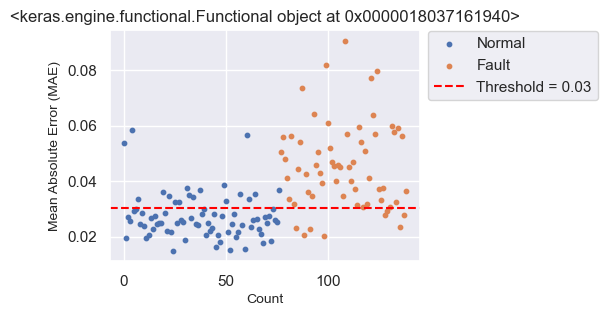

In [53]:
anomaly_threshold(threshold = 0.0305, model=autoencoder)

In [50]:
#for i in range(0,len(test_mae_loss)):
    
    
#    anomaly_threshold(test_mae_loss[i],'Autoencoder')
#    print('threshold'+ ' = ' + str(test_mae_loss[i]))
#    print('-----------------------------------------------------------------------------------------')
#    print('\n')